In [1]:
import heapq
import numpy as np
import scipy.sparse
from sklearn import linear_model
import sys, os
import jax.numpy as jnp
import jax

from utils_mondrian import sample_cut

stable_sigmoid = lambda x: jnp.exp(jax.nn.log_sigmoid(x))

def evaluate_all_lifetimes(X, y, X_test, y_test, M, lifetime_max, delta, c_value):
    """
    Sweeps through Mondrian kernels with all lifetime in [0, lifetime_max]. This can be used to (1) construct a Mondrian
    feature map with lifetime lifetime_max, to (2) find a suitable lifetime (inverse kernel width), or to (3) compare
    Mondrian kernel to Mondrian forest across lifetimes.
    :param X:                       training inputs
    :param y:                       training regression targets
    :param X_test:                  test inputs
    :param y_test:                  test regression targets
    :param M:                       number of Mondrian trees
    :param lifetime_max:            terminal lifetime
    :param delta:                   ridge regression regularization hyperparameter
    :param validation:              flag indicating whether a validation set should be created by halving the test set
    :return: dictionary res containing all results
    """

    N, D = np.shape(X)
    N_test = np.shape(X_test)[0]
    X_all = np.array(np.r_[X, X_test])
    N_all = N + N_test
    
    y_train = np.squeeze(y)
    y_test = np.squeeze(y_test)

    # initialize sparse feature matrix
    indptr = range(0, M * N_all + 1, M)
    indices = list(range(M)) * N_all
    data = np.ones(N_all * M)
    Z_all = scipy.sparse.csr_matrix((data, indices, indptr), shape=(N_all, M))
    feature_from_repetition = list(range(M))
    C = M

    # bounding box for all datapoints used to sample first cut in each tree
    feature_data = [np.array(range(N_all)) for _ in range(M)]
    lX = np.min(X_all, 0)
    uX = np.max(X_all, 0)

    # event = tuple (time, tree, feature, dim, loc), where feature is the index of feature being split
    events = []
    active_features = []
    cuts = []
    feature_indices = []
    active_features_in_tree = [[] for _ in range(M)]
    for m in range(M):
        cut_time, dim, loc = sample_cut(lX, uX, 0.0)
        if cut_time < lifetime_max:
            heapq.heappush(events, (cut_time, m, m, dim, loc))
        active_features.append(m)
        active_features_in_tree[m].append(m)

    # iterate through birth times in increasing order
    list_times = []
    w_kernel = np.zeros(M)

    parent = {}

    while len(events) > 0:
        (birth_time, m, c, dim, loc) = heapq.heappop(events)
        list_times.append(birth_time)
        
        # construct new feature
        Xd = X_all[feature_data[c], dim]
        feature_l = (feature_data[c])[Xd <= loc]
        feature_r = (feature_data[c])[Xd  > loc]
        feature_data.append(feature_l)
        feature_data.append(feature_r)

        active_features.remove(c)
        active_features_in_tree[m].remove(c)
        active_features.append(C + 0)
        active_features.append(C + 1)
        active_features_in_tree[m].append(C + 0)
        active_features_in_tree[m].append(C + 1)
        feature_indices.append(dim)
        #feature_indices.append(dim)
        cuts.append([loc, 0])
        parent[C + 0] = c
        parent[C + 1] = c
        #cuts.append([loc, 1])

        # move datapoints from split feature to child features
        Z_all.indices[feature_l * M + m] = C + 0
        Z_all.indices[feature_r * M + m] = C + 1
        Z_all = scipy.sparse.csr_matrix((Z_all.data, Z_all.indices, Z_all.indptr), shape=(N_all, C + 2), copy=False)

        # sample the cut for each child
        lX_l = np.min(X_all[feature_l, :], axis=0)
        uX_l = np.max(X_all[feature_l, :], axis=0)
        cut_time_l, dim_l, loc_l = sample_cut(lX_l, uX_l, birth_time)
        lX_r = np.min(X_all[feature_r, :], axis=0)
        uX_r = np.max(X_all[feature_r, :], axis=0)
        cut_time_r, dim_r, loc_r = sample_cut(lX_r, uX_r, birth_time)

        # add new cuts to heap
        if cut_time_l < lifetime_max:
            heapq.heappush(events, (cut_time_l, m, C + 0, dim_l, loc_l))
        if cut_time_r < lifetime_max:
            heapq.heappush(events, (cut_time_r, m, C + 1, dim_r, loc_r))

        feature_from_repetition.append(m)
        feature_from_repetition.append(m)
        C += 2

        # update Mondrian kernel predictions
        w_kernel = np.append(w_kernel, [w_kernel[c], w_kernel[c]])
        w_kernel[c] = 0
        Z_train = Z_all[:N]
        Z_test = Z_all[N:]

        clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
        clf.fit(Z_train, y_train, coef_init=w_kernel)
        w_kernel = clf.coef_

        y_hat_test = Z_test.dot(w_kernel)
        error_test = np.mean((y_test - y_hat_test) ** 2)


        sys.stdout.write("\rTime: %.2E / %.2E (C = %d, test error = %.3f)" % (birth_time, lifetime_max, C, error_test))
        sys.stdout.flush()
    
    sys.stdout.write("\n")

    cuts = np.array(cuts)
    
    path_map = np.zeros(shape=(C, M))
    for i in range(M, C):
        v = np.copy(path_map[:, parent[i]])
        v[i] = 1
        v = v[...,None]
        path_map = np.hstack((path_map, v))
    path_map = path_map[M:, M:]

    
    threshold = cuts[:, 0]

    feature_indices = np.array(feature_indices)
    
    
    def get_feature(X_all, Z_all, feature_indices, threshold, c):
        hidden_features = X_all[:, feature_indices]
        right_indicator = stable_sigmoid(c * (hidden_features - threshold))
        left_indicator = 1.0 - right_indicator
        soft_indicator = jnp.ravel(jnp.array([left_indicator.flatten(),right_indicator.flatten()]),order="F").reshape(
            (len(X_all), len(feature_indices)*2)
        )
        F_leaf = jnp.multiply(soft_indicator, Z_all)
        F_leaf = jnp.matmul(F_leaf, path_map)
        return F_leaf

    F_leaf = get_feature(X, Z_train[:, M:].todense(), feature_indices, threshold, c_value)
    clf = linear_model.SGDRegressor(alpha=delta, fit_intercept=False)
    clf.fit(F_leaf, y_train, coef_init=w_kernel[M:])
    w_kernel = clf.coef_
    
    
    def predict(x, Z_all, feature_indices, threshold, beta, c):
        hidden_features = x[feature_indices]
        right_indicator = stable_sigmoid(c * (hidden_features - threshold))
        left_indicator = 1.0 - right_indicator
        soft_indicator = jnp.ravel(jnp.array([left_indicator,right_indicator]),order="F")
        F_leaf = jnp.multiply(soft_indicator, Z_all)
        F_leaf = jnp.matmul(F_leaf, path_map)
        return jnp.dot(F_leaf, beta)
    
    
    fs = jax.jit(jax.vmap(predict, in_axes=(0, 0, None, None, None, None), out_axes=0))
    grad_fs = jax.jit(jax.vmap(jax.grad(predict, argnums=0), in_axes=(0, 0, None, None, None, None), out_axes=0))
    
    y_hat = fs(X_all, Z_all[:, M:].todense(), feature_indices, threshold, w_kernel, c_value)
    y_hat_test = y_hat[N:]
    error_test = np.mean((y_test - y_hat_test) ** 2)
    #print(error_test)

    grads = np.array(grad_fs(X_all[N:], Z_all[N:, M:].todense(), feature_indices, threshold, w_kernel, c_value))
    # this function returns a dictionary with all values of interest stored in it
    return grads, y_hat_test, feature_indices

In [2]:
def simulate_y(x):
    y = x[:, 0]**5 + x[:, 1]**4 + x[:, 2]**3 + x[:, 3]**2 + x[:, 4]**6
    return y

import matplotlib.pyplot as plt
def draw(dim_in, psi_est, labels = None):
    x = np.linspace(0, dim_in-1, dim_in)
    fig, ax = plt.subplots()

    ax.plot(x, psi_est, linewidth=1.0, label = "diag")
    if labels is not None:
        plt.xticks(x, labels)
    plt.legend()
    plt.show()

Time: 9.99E-03 / 1.00E-02 (C = 672, test error = 0.101)


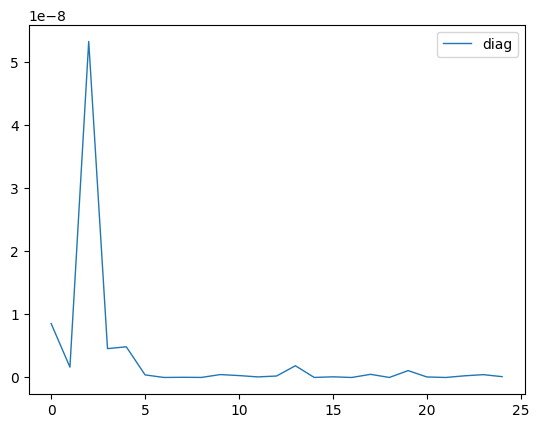

In [3]:
dim_in = 25
x = np.random.rand(100,dim_in)*2 - 1
x_test = np.random.rand(100,dim_in)*2 - 1
y = simulate_y(x)
y_test = simulate_y(x_test)

###############################
x[:, :5] = x[:, :5] * 10
x_test[:, :5] = x_test[:, :5] * 10
###############################

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.01          # terminal lifetime
delta = 0.01

grads, y_hat_test, feature_indices = evaluate_all_lifetimes(x, y, x_test, y_test, M, lifetime_max, delta, 0.001)

draw(dim_in, np.mean(grads**2, axis = 0))

<AxesSubplot: ylabel='count'>

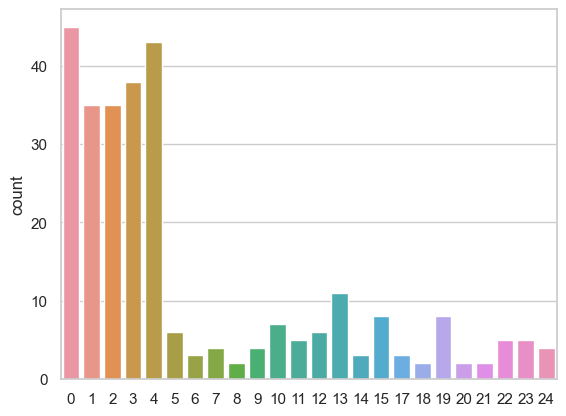

In [4]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=feature_indices)

In [5]:
np.mean((y_test - y_hat_test) ** 2)

Array(0.12301674, dtype=float32)

Shapes: psi_est_all: (1000, 1, 100, 25), grad_train: (100, 25), psi_est: (25,)


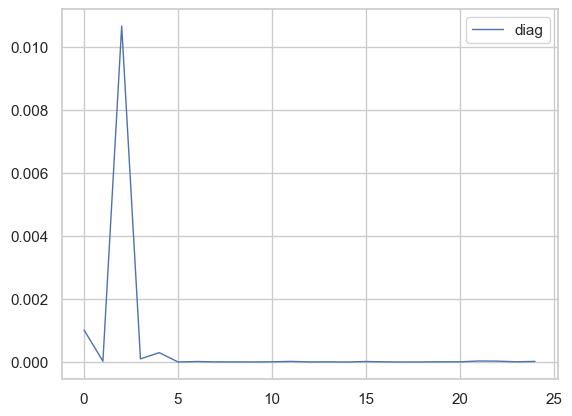

In [10]:
from vie import get_fdt_model
fdt_out = get_fdt_model(x, y, c=0.1, sig2=0.01, n_tree=100, 
                            compute_psi=True, batch_size=1, n_samp=10, seed=0)

grad_fs = fdt_out[2]
betas = fdt_out[3]["betas"]
f = fdt_out[1]
map_matrix = fdt_out[3]["map_matrix"]
feature = fdt_out[3]["feature"]
threshold = fdt_out[3]["threshold"]
beta = fdt_out[3]["beta"]
psi_est = np.array(grad_fs(x_test, map_matrix, feature, threshold, betas))
grad_train = np.mean(psi_est**2, axis=(0,1))
psi_test = np.median(grad_train, axis=0)

draw(dim_in, psi_test)

In [11]:
f = fdt_out[1]
map_matrix = fdt_out[3]["map_matrix"]
feature = fdt_out[3]["feature"]
threshold = fdt_out[3]["threshold"]
beta = fdt_out[3]["beta"]
pred_test = np.array(f(x_test, map_matrix, feature, threshold, beta))
np.mean((y_test - np.mean(pred_test, 1)) ** 2)

10.948908786879029

In [12]:
extra = fdt_out[4]
extra

ExtraTreesRegressor(max_leaf_nodes=64, random_state=0)

<AxesSubplot: ylabel='count'>

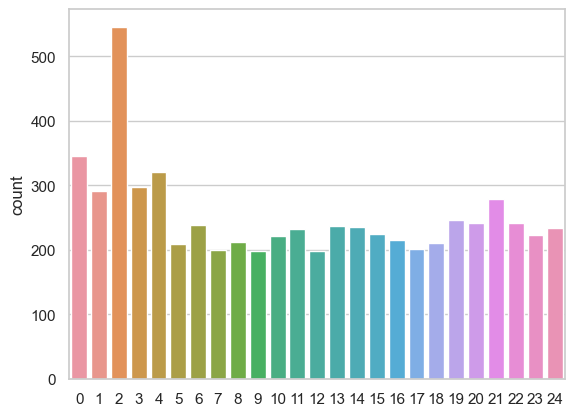

In [13]:
from fdt import fdt
features_stat = []
threshold_stat = []
beta_stat = []
for j, model in enumerate(extra.estimators_):
    m = fdt(model, x, y, c=0.1, sig2=0.01)
    m.train()
    features_stat = features_stat + list(m.hidden_features)
    #threshold_stat = threshold_stat + list(m.hidden_threshold)
    #beta_stat = beta_stat + list(m.beta)
sns.countplot(x=features_stat)